# Не бит, не крашен

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Загрузка данных

### Библиотеки

Импортируем библиотеки.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

И все используемое далее.

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

Отключаем лишние предупреждения.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Функции

#### calc_gscv

In [ ]:
def calc_gscv(model, features, target, params):
    '''
    Функция для поиска оптимальных параметров и расчета RMSE по этим параметрам на обучающей выборке.
    '''
    grid = GridSearchCV(model,
                        params,
                        #scoring = 'neg_mean_squared_error',
                        scoring = 'neg_root_mean_squared_error',
                        cv = 5,
                        n_jobs = -1)
    grid.fit(features,
             target)
    rmse = (-grid.best_score_)**0.5
    print('RMSE модели на обучающей выборке:{:.2f}'.format(rmse))
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)

#### column_values

In [ ]:
def column_values(data_frame):
    '''
    Функция для визуального поиска артефактов и выбросов в значениях DataFrame
    '''
    for column in data_frame.columns:
        print('\nЗначения столбца', column,':')
        print(data_frame[column].sort_values().unique())

#### df_info

In [ ]:
def df_info(data_frame):
    '''
    Функция выводящая первичную информацию о DataFrame
    '''
    print('\nРазмер таблицы: {} '.format(data_frame.shape))
    print('\nИнфо:')
    print(data_frame.info())                                            # сколько значений и в каком формате
    print('\nПропусков:')
    print(data_frame.isna().mean().sort_values(ascending=False) * 100)  # подсчёт пропусков в процентах
    print('\nОписание:')
    display(data_frame.describe())                                      # вдруг чего "на глазок" проявится 
    print('\nДубликатов =', data_frame.duplicated().sum())              # проверим дубликаты

### Таблица

Читаем файл с данными и сохраняем в df.

In [ ]:
try:
    path = '/datasets/'
    df = pd.read_csv(os.path.join(path, 'autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']))
except Exception:
    ! gdown --id 1WcybmU4TZoaSmsKgvtjwvcrBWKYTw1d2
    df = pd.read_csv('/content/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Смотрим табличку.

In [ ]:
display(df.columns)
print()
display(df.head())

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Описание данных

Признаки

	• DateCrawled         дата скачивания анкеты из базы
	• VehicleType         тип автомобильного кузова
	• RegistrationYear    год регистрации автомобиля
	• Gearbox             тип коробки передач
	• Power               мощность (л. с.)
	• Model               модель автомобиля
	• Kilometer           пробег (км)
	• RegistrationMonth   месяц регистрации автомобиля
	• FuelType            тип топлива
	• Brand               марка автомобиля
	• NotRepaired         была машина в ремонте или нет
	• DateCreated         дата создания анкеты
	• NumberOfPictures    количество фотографий автомобиля
	• PostalCode          почтовый индекс владельца анкеты (пользователя)
	• LastSeen            дата последней активности пользователя

Целевой признак

	• Price               цена (евро)

"Шапку" к стандартному виду.

In [ ]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
display(df.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### df_rus

Табличку к рабочему виду.

In [ ]:
df_rus = df.rename(columns={'date_crawled': 'дата_скачивания',
                            'vehicle_type': 'кузов',
                            'registration_year': 'год_регистрации',
                            'gearbox': 'кор_передач',
                            'power': 'мощность',
                            'model': 'модель',
                            'kilometer': 'пробег',
                            'registration_month': 'месяц_регистрации',
                            'fuel_type': 'топливо',
                            'brand': 'марка',
                            'not_repaired': 'ремонт',
                            'date_created': 'дата_анкеты',
                            'number_of_pictures': 'кол_фото',
                            'postal_code': 'почт_индекс_владельца',
                            'last_seen': 'посл_активн_пользователя'})
display(df_rus)

,дата_скачивания,цена,кузов,год_регистрации,кор_передач,мощность,модель,пробег,месяц_регистрации,топливо,марка,ремонт,дата_анкеты,кол_фото,почт_индекс_владельца,посл_активн_пользователя
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


#### Инфо

Посмотрим заполненость таблицы.

In [ ]:
df_info(df_rus)

# Добавим преобразование дат в чтение файла


Размер таблицы: (354369, 16) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   дата_скачивания           354369 non-null  object
 1   цена                      354369 non-null  int64 
 2   кузов                     316879 non-null  object
 3   год_регистрации           354369 non-null  int64 
 4   кор_передач               334536 non-null  object
 5   мощность                  354369 non-null  int64 
 6   модель                    334664 non-null  object
 7   пробег                    354369 non-null  int64 
 8   месяц_регистрации         354369 non-null  int64 
 9   топливо                   321474 non-null  object
 10  марка                     354369 non-null  object
 11  ремонт                    283215 non-null  object
 12  дата_анкеты               354369 non-null  object
 13  кол_фото             

,цена,год_регистрации,мощность,пробег,месяц_регистрации,кол_фото,почт_индекс_владельца
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Дубликатов = 4


##### Вывод

    - не корректный формат данных (не в формате даты):
        - дата_скачивания
        - дата_анкеты
        - посл_активн_пользователя
    - есть пропуски в
        - ремонт
        - кузов
        - топливо
        - кор_передач
        - модель
    - имеется 4 полных дубликата в строках

#### Анализ данных

Отлавливаем артефакты в данных.

In [ ]:
%%time
column_values(df_rus)


Значения столбца дата_скачивания :
['2016-03-05 14:06:22' '2016-03-05 14:06:23' '2016-03-05 14:06:24' ...
 '2016-04-07 14:36:55' '2016-04-07 14:36:56' '2016-04-07 14:36:58']

Значения столбца цена :
[    0     1     2 ... 19998 19999 20000]

Значения столбца кузов :
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Значения столбца год_регистрации :
[1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 

##### Вывод

    - "цена": 0, 1 и 2 - это привлекательно, но сомнительно
    - "год_регистрации" и "мощность": довольно разнообразный мусор, возможна техническая ошибка
    - "месяц_регистрации": месяца 0 не бывает
    - "дата_анкеты": 2015, и особенно 2014 представлены не полно
    - "кол_фото": фотографий нет нигде
    - "почт_индекс_владельца": выглядит сомнительно, ни одной правильной цифры, должно быть по 6 знаков (возможно закодировано)
    - "посл_активн_пользователя": отсутствуют данные за 2014 и 2015 год

## Подготовка данных

### Пропуски

#### 'ремонт' : 'not_repaired'

В колонке `ремонт` пропуски могут быть вызваны:

    - машина не чинилась;
    - машина чинилась, но это хотят скрыть. 

Заполним пропуски значением unknown.

In [ ]:
df['not_repaired'] = df['not_repaired'].fillna('unknown')
#df.isna().mean().sort_values(ascending=False) * 100

#### 'модель' : 'model'

Модель авто влияет на цену. У каждого бренда больше 1 модели, поэтому заполнить корректно пропуски невозможно. 

Пропусков 5,6%. Удаляем.

Сначала обрабатываем "модель", потом остальное.

In [ ]:
df = df.loc[~df['model'].isna()]
#df.isna().mean().sort_values(ascending=False) * 100

#### 'кузов' : 'vehicle_type'

#### 'кор_передач' : 'gearbox'

#### 'топливо' : 'fuel_type'

Тип кузова и топлива, а также коробку передач восстановим по марке и модели, используя наиболее частые значения.

In [ ]:
df['vehicle_type'] = df['vehicle_type'].fillna(
                              df.groupby('model')['vehicle_type'].transform(
                                    lambda x: x.value_counts().idxmax()))
df['gearbox'] = df['gearbox'].fillna(
                              df.groupby('model')['gearbox'].transform(
                                    lambda x: x.value_counts().idxmax()))
df['fuel_type'] = df['fuel_type'].fillna(
                              df.groupby('model')['fuel_type'].transform(
                                    lambda x: x.value_counts().idxmax()))
df.isna().mean().sort_values(ascending=False) * 100

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
not_repaired          0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

### Аномалии

#### 'цена' : 'price'

Посмотрим распределение цен.

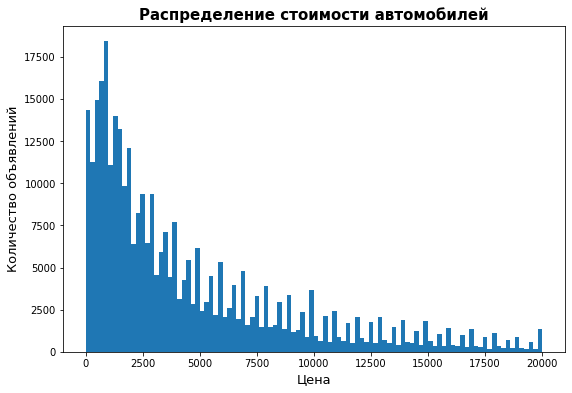

Количество строк ценой до 200 евро:  16107
Процент строк ценой до 200 евро: 4.81%


In [ ]:
df['price'].hist(bins = 100,
                 figsize = (9,6),
                 grid = False)
plt.xlabel('Цена',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
#plt.xlim([0, 500])
plt.title('Распределение стоимости автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

print('Количество строк ценой до 200 евро: ',len(df.loc[df['price'] <= 200]))
print('Процент строк ценой до 200 евро: {:.2%}'.format(len(df.loc[df['price'] <= 200]) / len(df)))

Просмотр на увеличенном масштабе начала графика позволяет отсеч значения цен до 200 евро.

Цены в 0, 1, 2 и т.д. евро быть не может, а график подсказал, что вторая "ступень" начинается с 200.

Жертвуем 4.81% данных.

In [ ]:
df = df.loc[df['price'] > 200]

Проверяем.

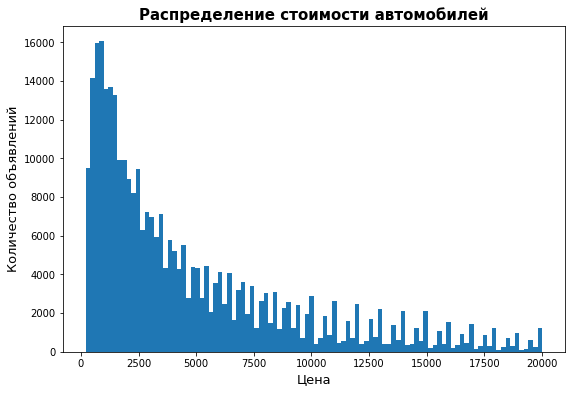

In [ ]:
df['price'].hist(bins = 100,
                 figsize = (9,6),
                 grid = False)
plt.xlabel('Цена',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение стоимости автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'год_регистрации' : 'registration_year'

Посмотрим распределение по годам регистрации.

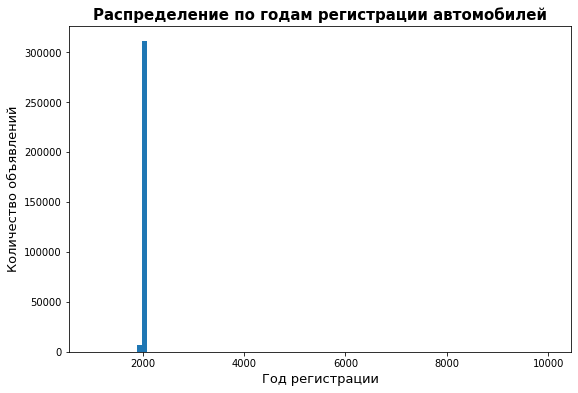

Количество строк до 1960:  166
Процент строк до 1960: 0.05%

Количество строк после 2016:  11753
Процент строк после 2016: 3.69%

Итого: 3.74%


In [ ]:
df['registration_year'].hist(bins = 100,
                             figsize = (9,6),
                             grid = False)
plt.xlabel('Год регистрации',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
#plt.xlim([1959, 2017])
plt.title('Распределение по годам регистрации автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

print('\nКоличество строк до 1960: ', len(df.loc[df['registration_year'] < 1960]))
print('Процент строк до 1960: {:.2%}'.format(len(df.loc[df['registration_year'] < 1960]) / len(df)))
print('\nКоличество строк после 2016: ', len(df.loc[df['registration_year'] > 2016]))
print('Процент строк после 2016: {:.2%}'.format(len(df.loc[df['registration_year'] > 2016]) / len(df)))
print('\nИтого: {:.2%}'.format(len(df.loc[df['registration_year'] < 1960]) / len(df) + 
                               len(df.loc[df['registration_year'] > 2016]) / len(df)))

Отсекаем значения более 2016 т.к. данные предоставлены до '2016-04-07 14:58:51' и менее 1960 (согласно графика).

In [ ]:
df = df.loc[(df['registration_year'] >= 1960) & 
            (df['registration_year'] <= 2016)]

Проверяем.

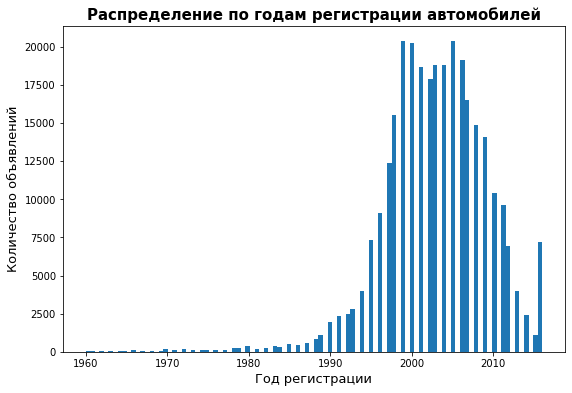

In [ ]:
df['registration_year'].hist(bins = 100,
                             figsize = (9,6),
                             grid = False)
plt.xlabel('Год регистрации',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по годам регистрации автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'мощность' : 'power'

Посмотрим распределение мощностей/

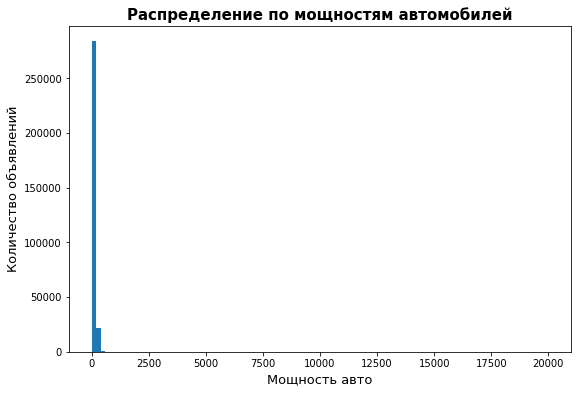

Количество строк до 50 л.с.:  30159
Процент строк до 50 л.с.: 9.84%

Количество строк выше 600:  340
Процент строк выше 600: 0.11%

Итого: 9.95%


In [ ]:
df['power'].hist(bins = 100,
                 figsize = (9,6),
                 grid = False)
plt.xlabel('Мощность авто',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
#plt.xlim([0, 600])
plt.title('Распределение по мощностям автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

print('\nКоличество строк до 50 л.с.: ', len(df.loc[df['power'] < 50]))
print('Процент строк до 50 л.с.: {:.2%}'.format(len(df.loc[df['power'] < 50]) / len(df)))
print('\nКоличество строк выше 600: ', len(df.loc[df['power'] > 500]))
print('Процент строк выше 600: {:.2%}'.format(len(df.loc[df['power'] > 500]) / len(df)))
print('\nИтого: {:.2%}'.format(len(df.loc[df['power'] < 50]) / len(df) + 
                               len(df.loc[df['power'] > 500]) / len(df)))

Убираем значения менее 50 л.с. т.к. даже ВАЗ2101 имел 64 и более 600 (согласно графика).

Это еще 9.95%.

In [ ]:
df = df.loc[(df['power'] >= 50) & 
            (df['power'] <= 500)]

Проверяем.

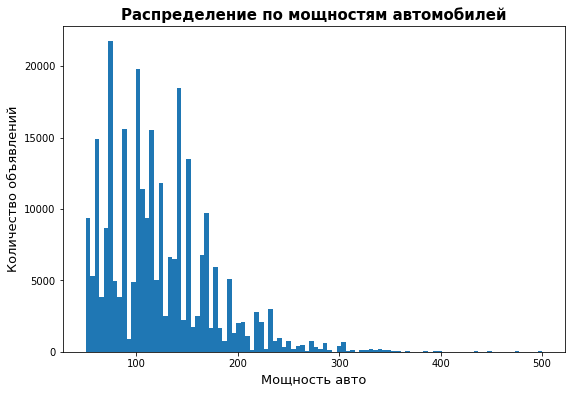

In [ ]:
df['power'].hist(bins = 100,
                 figsize = (9,6),
                 grid = False)
plt.xlabel('Мощность авто',
           fontsize = 13)
plt.ylabel('Количество объявлений',
           fontsize = 13)
plt.title('Распределение по мощностям автомобилей',
          fontsize = 15,
          fontweight = 'bold')
plt.show()

#### 'дата_скачивания' : 'date_crawled'

#### 'дата_анкеты' : 'date_created'

#### 'посл_активн_пользователя' : 'last_seen'

#### 'кол_фото' : 'number_of_pictures'

#### 'месяц_регистрации' : 'registration_month'

    - Колонки `дата_скачивания` (date_crawled), `дата_анкеты` (date_created) и `посл_активн_пользователя` (last_seen) на цену не влияют.
    - Фотографий ('number_of_pictures') нигде нет.
    - Возраст автомобиля определяют по году регистрации, не учитывая месяц ('registration_month').

Эти 5 колонок и удаляем.

In [ ]:
df=df.drop(['date_crawled',
            'date_created',
            'last_seen',
            'number_of_pictures',
            'registration_month'],
            axis = 1)

Поменяем формат столбцов gearbox и not_repaired на булевый тип, чтобы без вариантов одно из двух значений.

In [ ]:
df['manual_gearbox'] = 0                                 # 0 - автоматическая коробка передач
df.loc[df['gearbox'] == 'manual', 'manual_gearbox'] = 1  # 1 - механическая коробка передач
display(df['manual_gearbox'].value_counts())
display(df['gearbox'].value_counts())

df['is_not_repaired'] = 0                                  # не ремонтировалась
df.loc[df['not_repaired'] == 'yes', 'is_not_repaired'] = 1 # ремонтировалась
display(df['is_not_repaired'].value_counts())
display(df['not_repaired'].value_counts())

1    219807
0     56332
Name: manual_gearbox, dtype: int64

manual    219807
auto       56332
Name: gearbox, dtype: int64

0    251064
1     25075
Name: is_not_repaired, dtype: int64

no         214594
unknown     36470
yes         25075
Name: not_repaired, dtype: int64

Удалим теперь ненужные столбцы.

In [ ]:
df.drop(['not_repaired','gearbox'], inplace=True, axis=1)

Почистим дубликаты.

In [ ]:
df = df.drop_duplicates()

Посмотрим получившуюся таблицу.

In [ ]:
display(df.head())
df_info(df)
print('\nВсего было удалено: {:.2%}'.format((len(df_rus) - len(df)) / len(df_rus)),' строк.')

Проверим признаки на независимость.

,price,vehicle_type,registration_year,power,model,kilometer,fuel_type,brand,postal_code,manual_gearbox,is_not_repaired
2,9800,suv,2004,163,grand,125000,gasoline,jeep,90480,0,0
3,1500,small,2001,75,golf,150000,petrol,volkswagen,91074,1,0
4,3600,small,2008,69,fabia,90000,gasoline,skoda,60437,1,0
5,650,sedan,1995,102,3er,150000,petrol,bmw,33775,1,1
6,2200,convertible,2004,109,2_reihe,150000,petrol,peugeot,67112,1,0



Размер таблицы: (252879, 11) 

Инфо:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 252879 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              252879 non-null  int64 
 1   vehicle_type       252879 non-null  object
 2   registration_year  252879 non-null  int64 
 3   power              252879 non-null  int64 
 4   model              252879 non-null  object
 5   kilometer          252879 non-null  int64 
 6   fuel_type          252879 non-null  object
 7   brand              252879 non-null  object
 8   postal_code        252879 non-null  int64 
 9   manual_gearbox     252879 non-null  int64 
 10  is_not_repaired    252879 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 23.2+ MB
None

Пропусков:
price                0.0
vehicle_type         0.0
registration_year    0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type

,price,registration_year,power,kilometer,postal_code,manual_gearbox,is_not_repaired
count,252879.000000,252879.000000,252879.000000,252879.000000,252879.000000,252879.000000,252879.000000
mean,4998.097818,2003.105671,122.371996,128377.425567,51693.126539,0.796990,0.094223
std,4625.693087,6.150703,52.418517,36502.085134,25747.869595,0.402241,0.292139
min,202.000000,1960.000000,50.000000,5000.000000,1067.000000,0.000000,0.000000
25%,1450.000000,1999.000000,82.000000,125000.000000,31228.000000,1.000000,0.000000
50%,3350.000000,2003.000000,115.000000,150000.000000,50827.000000,1.000000,0.000000
75%,7199.000000,2007.000000,150.000000,150000.000000,72505.000000,1.000000,0.000000
max,20000.000000,2016.000000,500.000000,150000.000000,99998.000000,1.000000,1.000000



Дубликатов = 0

Всего было удалено: 28.64%  строк.


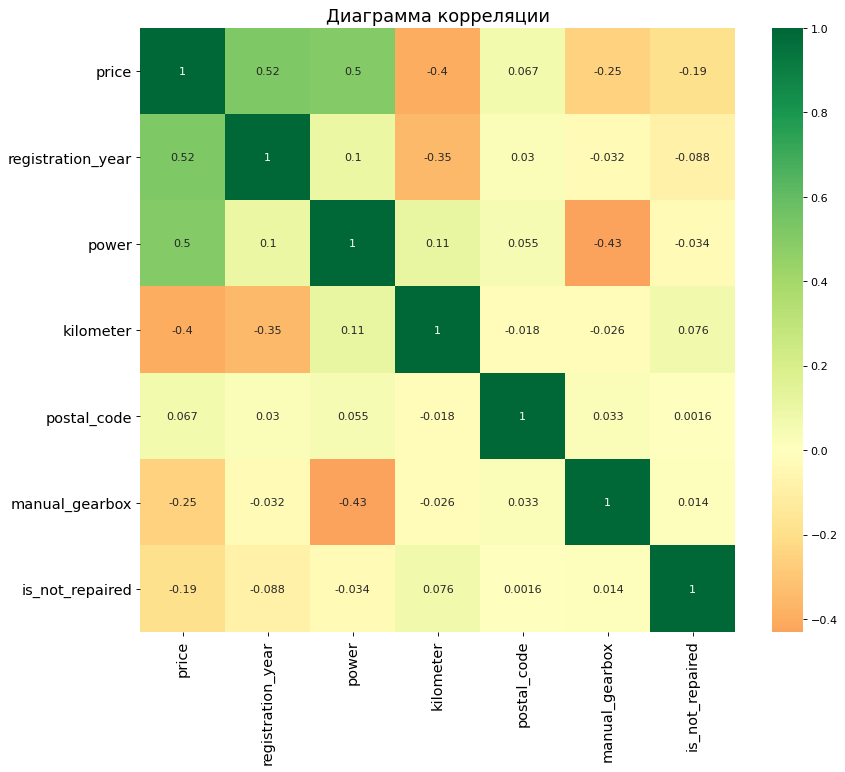

In [ ]:
plt.figure(figsize=(12, 10),
           dpi=80)
sns.heatmap(df.corr(),
            xticklabels=df.corr().columns,
            yticklabels=df.corr().columns,
            cmap='RdYlGn',
            center=0,
            annot=True)
plt.title('Диаграмма корреляции', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Обучение моделей

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

Примечания:

	• Для оценки качества моделей применяйте метрику RMSE.
	• Значение метрики RMSE должно быть меньше 2500.
	• Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
	• Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
	• Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
	• Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

Скопировать кодPYTHON

`del features_train`

Создадим обучающую и тестовую выборки в соотношении 75:25.

In [ ]:
target = df['price']
features = df.drop('price',
                   axis = 1)
features_train, features_test, target_train, target_test = train_test_split(
                                                                    features,
                                                                    target,
                                                                    test_size = 0.25,
                                                                    random_state = 1980)
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (189659, 10) (189659,)
Тестовая выборка:  (63220, 10) (63220,)


Для более простых моделей используем кодирование OHE.

In [ ]:
df_ohe = pd.get_dummies(df, 
                        drop_first = True)
#display(df_ohe.head(5))
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop('price', 
                           axis = 1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
                                                                                    features_ohe,
                                                                                    target_ohe,
                                                                                    test_size = 0.25,
                                                                                    random_state = 1980)
print('Обучающая выборка: ', features_train_ohe.shape,  target_train_ohe.shape)
print('Тестовая выборка: ', features_test_ohe.shape,  target_test_ohe.shape)
df_ohe

Обучающая выборка:  (189659, 305) (189659,)
Тестовая выборка:  (63220, 305) (63220,)


,price,registration_year,power,kilometer,postal_code,manual_gearbox,is_not_repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
2,9800,2004,163,125000,90480,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,91074,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,2008,69,90000,60437,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,650,1995,102,150000,33775,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2200,2004,109,150000,67112,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,51371,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,96465,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354366,1199,2000,101,125000,26135,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
354367,9200,1996,102,150000,87439,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Константная модель

Создадим константную модель, которая любому объекту будет предсказывать среднее значение и посчитаем для нее метрику RMSE. С ней и будем сравнивать все последующие модели.

In [ ]:
%%time
predicted_const = pd.Series(target_test.mean(),
                            index = target_test.index)
rmse_const = mean_squared_error(target_test, predicted_const)**0.5
predict_time_const = '3.48 ms'
print('RMSE константной модели: {:.2f}'. format(rmse_const))

RMSE константной модели: 4635.53
CPU times: user 3.06 ms, sys: 298 µs, total: 3.36 ms
Wall time: 2.34 ms


### LinearRegression

In [ ]:
# RMSE модели на обучающей выборке:2541.89
# Лучшие гиперпараметры для модели:  {'copy_X': True, 'normalize': False}
# CPU times: user 4min 38s, sys: 3min, total: 7min 39s
# Wall time: 7min 42s
'''
%%time
lr = LinearRegression()
params_lr = {'normalize':[True,False],
             'copy_X':[True, False]}
calc_gscv(lr,
          features_train_ohe,
          target_train_ohe,
          params_lr)
'''
learning_time_lr = '7min 42s'

### DecisionTreeRegressor

In [ ]:
# RMSE модели на обучающей выборке:1899.29
# Лучшие гиперпараметры для модели:  {'max_depth': 16, 'splitter': 'best'}
# CPU times: user 1min 38s, sys: 8.59 s, total: 1min 47s
# Wall time: 1min 47s
'''
%%time
dtr = DecisionTreeRegressor(random_state=1980)
params_dtr = {'max_depth': range(1, 20, 5), # проверялось до (1, 50, 5)
              'splitter': ['best', 'random']}
calc_gscv(dtr,
          features_train_ohe,
          target_train_ohe,
          params_dtr )
'''
learning_time_dtr = '1min 47s'

### CatBoost

Создадим список категориальных признаков.

In [ ]:
features_cbr = ['vehicle_type',
                'manual_gearbox',
                'model',
                'fuel_type',
                'brand',
                'is_not_repaired']

In [ ]:
# RMSE модели CatBoost на обучающей выборке:1564.03
# Лучшие гиперпараметры для модели:  {'depth': 15, 'learning_rate': 0.3}
# CPU times: user 14min 37s, sys: 3min 35s, total: 18min 12s
# Wall time: 18min 30s
'''
%%time
#Ищем лучшие параметры и метрику RMSE на обучающей выборке с этими параметрами
cbr = CatBoostRegressor(iterations = 100,
                        verbose = False,
                        cat_features = features_cbr)
params_cbr = {'learning_rate':[0.1, 0.3, 0.5],
              'depth':[5,10, 15]} 
grid_cbr = GridSearchCV(cbr,
                        params_cbr,
                        scoring = 'neg_mean_squared_error',
                        cv = 3,
                        n_jobs = -1)
grid_cbr.fit(features,
             target)
rmse = (-grid_cbr.best_score_)**0.5
print('RMSE модели CatBoost на обучающей выборке:{:.2f}'.format(rmse))
print('Лучшие гиперпараметры для модели: ', grid_cbr.best_params_)
'''
learning_time_cbr = '18min 30s'

### LightGBM

Меняем тип категориальных признаков на 'category'.

In [ ]:
df_lgbmr = df
df_lgbmr[['vehicle_type',
          'manual_gearbox',
          'model',
          'fuel_type',
          'brand',
          'is_not_repaired']] = df_lgbmr[['vehicle_type',
                                          'manual_gearbox',
                                          'model',
                                          'fuel_type',
                                          'brand',
                                          'is_not_repaired']].astype('category')

Пересоздадим обучающую и тестовую выборки.

In [ ]:
target_lgbmr = df_lgbmr['price']
features_lgbmr = df_lgbmr.drop('price',
                               axis = 1)
features_train_lgbmr, features_test_lgbmr, target_train_lgbmr, target_test_lgbmr = train_test_split(
                                                                                         features_lgbmr,
                                                                                         target_lgbmr, 
                                                                                         test_size = 0.25, 
                                                                                         random_state = 1980)

In [ ]:
%%time
estim = LGBMRegressor(random_state = 1980)
params = {'n_estimators': [60, 150],
          'num_leaves': [21, 51, 101],
          'learning_rate':[0.1, 0.3, 0.5],
          'boosting_type':['gbdt', 'dart', 'goss']
         }
grid_lgbmr = GridSearchCV(estimator = estim, 
                          param_grid = params, 
                          cv = 3,
                          #scoring = 'neg_mean_squared_error',
                          scoring = 'neg_root_mean_squared_error',
                          n_jobs = -1)

CPU times: user 69 µs, sys: 7 µs, total: 76 µs
Wall time: 80.1 µs


In [ ]:
%%time
# RMSE модели LightGBM на обучающей выборке:-2324643.19
# Лучшие гиперпараметры для модели:  {'boosting_type': 'dart', 'learning_rate': 0.3, 'n_estimators': 150, 'num_leaves': 101}
# CPU times: user 57.9 s, sys: 2 s, total: 59.9 s
# Wall time: 11min 40s
'''
grid_lgbmr.fit(features_lgbmr, target_lgbmr)
print('RMSE модели LightGBM на обучающей выборке:{:.2f}'.format(grid_lgbmr.best_score_))
print('Лучшие гиперпараметры для модели: ',grid_lgbmr.best_params_)
'''
learning_time_lgbmr = '11min 40s'

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


## Анализ моделей

### LinearRegression

Обучим модель Линейной регрессии с найденными параметрами на тестовой выборке.

In [ ]:
%%time
test_lr = LinearRegression(copy_X = True,
                           normalize = False)
test_lr.fit(features_train_ohe,
            target_train_ohe)
fit_time_lr = '40.4 s'

CPU times: user 13.4 s, sys: 7.12 s, total: 20.5 s
Wall time: 20.5 s


In [ ]:
%%time
predictions_lr = test_lr.predict(features_test_ohe)
mse = mean_squared_error(target_test_ohe,
                         predictions_lr)
rmse_lr = mse.mean()**0.5
predict_time_lr = '277 ms'
print('RMSE модели Линейной регресии на тестовой выборке: {:.2f}'.format(rmse_lr))

RMSE модели Линейной регресии на тестовой выборке: 2574.69
CPU times: user 115 ms, sys: 130 ms, total: 245 ms
Wall time: 292 ms


### DecisionTreeRegressor

Обучим модель Решающего дерева с найденными параметрами на тестовой выборке.

In [ ]:
%%time
test_dtr = DecisionTreeRegressor(random_state = 1980, 
                                 max_depth = 16)
test_dtr.fit(features_train_ohe,
             target_train_ohe)
fit_time_dtr = '5.57 s'

CPU times: user 4.3 s, sys: 272 ms, total: 4.57 s
Wall time: 4.65 s


In [ ]:
%%time
predictions_dtr = test_dtr.predict(features_test_ohe)
mse = mean_squared_error(target_test_ohe,
                         predictions_dtr)
rmse_dtr = mse.mean()**0.5
predict_time_dtr = '131 ms'
print('RMSE модели Решающего дерева на тестовой выборке: {:.2f}'.format(rmse_dtr))

RMSE модели Решающего дерева на тестовой выборке: 1845.77
CPU times: user 57.1 ms, sys: 60.3 ms, total: 117 ms
Wall time: 120 ms


### CatBoostRegressor

Обучим модель CatBoost на тестовой выборке.

In [ ]:
%%time
test_cbr = CatBoostRegressor(iterations = 100,
                             verbose = False,
                             cat_features = features_cbr,
                             learning_rate = 0.3,
                             depth = 15,
                             random_state = 1980)
test_cbr.fit(features_train,
             target_train)
fit_time_cbr = '1min 22s'

CPU times: user 56.5 s, sys: 19.6 s, total: 1min 16s
Wall time: 1min 16s


In [ ]:
%%time
predictions_cbr = test_cbr.predict(features_test)
mse = mean_squared_error(target_test,
                         predictions_cbr)
rmse_cbr = mse.mean()**0.5
predict_time_cbr = '162 ms'
print('RMSE модели CatBoost на тестовой выборке: {:.2f}'.format(rmse_cbr))

RMSE модели CatBoost на тестовой выборке: 1551.72
CPU times: user 158 ms, sys: 0 ns, total: 158 ms
Wall time: 161 ms


### LGBMRegressor

Обучим модель LightGBM на тестовой выборке.

In [ ]:
%%time
categorial_features = ['vehicle_type',
                       'manual_gearbox',
                       'model',
                       'fuel_type',
                       'brand',
                       'is_not_repaired']
test_lgbmr = LGBMRegressor(iterations = 100,
                           verbose = 0,
                           random_state = 1980,
                           categorial_features = categorial_features,
                           learning_rate = 0.3,
                           n_estimators = 150,
                           num_leaves = 101,
                           depth = 5,
                           boosting_type = 'dart')
test_lgbmr.fit(features_train_lgbmr,
               target_train_lgbmr)
fit_time_lgbmr = '31min 16s'

[LightGBM] [Warning] Unknown parameter: categorial_features
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: categorial_features
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
CPU times: user 30min 41s, sys: 13.2 s, total: 30min 54s
Wall time: 31min 15s


In [ ]:
%%time
predictions_lgbmr = test_lgbmr.predict(features_test_lgbmr)
mse = mean_squared_error(target_test_lgbmr,predictions_lgbmr)
rmse_lgbmr = mse.mean()**0.5
predict_time_lgbmr = '1.48 s'
print('RMSE для модели LGBM на тестовой выборке: {:.2f}'.format(rmse_lgbmr))

RMSE для модели LGBM на тестовой выборке: 1517.16
CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.31 s


### Сводная таблица

Все посчитанное в одну табличку.

In [ ]:
pivot = {"Модель":np.array(['Константная',
                            'LinearRegression',
                            'DecisionTreeRegressor',
                            'CatBoost',
                            'LightGBM']),
         "RMSE":np.array([rmse_const,
                          rmse_lr,
                          rmse_dtr,
                          rmse_cbr,
                          rmse_lgbmr]),
         "Время обучения":np.array(['-',
                                    fit_time_lr,
                                    fit_time_dtr,
                                    fit_time_cbr,
                                    fit_time_lgbmr]),
         "Время предсказания":np.array([predict_time_const,
                                        predict_time_lr,
                                        predict_time_dtr,
                                        predict_time_cbr,
                                        predict_time_lgbmr]),
         "Время подбора параметров":np.array(['-',
                                              learning_time_lr,
                                              learning_time_dtr,
                                              learning_time_cbr,
                                              learning_time_lgbmr])}
learning_time_lr = '7min 42s'
data = pd.DataFrame(pivot, index=['1', '2', '3', '4', '5'])
display(data)

,Модель,RMSE,Время обучения,Время предсказания,Время подбора параметров
1,Константная,4635.530614,-,3.48 ms,-
2,Линейная регрессия,2574.689444,40.4 s,277 ms,7min 42s
3,Решающее дерево,1845.768646,5.57 s,131 ms,1min 47s
4,CatBoost,1551.722902,1min 22s,162 ms,18min 30s
5,LightGBM,1517.161773,31min 16s,1.48 s,11min 40s


## Вывод

В ходе проекта были реализованы и протестированы несколько моделей предсказания рыночной стоимости своего автомобиля.

Требуемые параметры моделей сведены в приведенную выше таблицу.

Наименьшую среднюю ошибку (RMSE) показали модели:

    1. LightGBM              1518
    2. CatBoost              1552
    3. Решающее дерево       1852
    
Самыми быстрыми при обучении получились модели:

    1. Решающее дерево       3.48 ms
    2. Линейная регрессия    42.5 s
    3. CatBoost              1min 22s
    
Самыми быстрыми на предсказании получились модели:

    1. Решающее дерево       131 ms
    2. CatBoost              162 ms	
    3. Линейная регрессия    277 ms	

Получилось чем быстрее просчитывается результат, тем он менее точен.

В дополнительных условиях было указано "Значение метрики RMSE должно быть меньше 2500". Тогда быстрейшая модель обеспечивающая достаточную точность - это Решающее дерево.